# (1) Load the dataset and import libraries

In [1]:
# Importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load Firepoints Data

kerala_clean_merge_data = pd.read_csv("/content/drive/MyDrive/BITS_PILANI_RESEARCH/Data/KeralaFireWeatherAWS_merged.csv", encoding='latin1')
print(kerala_clean_merge_data.head())

  DISTRICT   STATION DATE(YYYY-MM-DD) TIME (UTC)  \
0   IDUKKI  PEERMADE       2022-12-14   00:30:00   
1   IDUKKI  PEERMADE       2022-12-14   01:30:00   
2   IDUKKI  PEERMADE       2022-12-14   02:30:00   
3   IDUKKI  PEERMADE       2022-12-14   03:30:00   
4   IDUKKI  PEERMADE       2022-12-14   04:30:00   

   RAIN FALL CUM. SINCE 0300 UTC (mm)  TEMP. ('C)  RH (%)  \
0                                 2.5        18.9    99.0   
1                                 2.5        19.1    97.0   
2                                 2.5        19.5    95.0   
3                                 0.0        20.3    91.0   
4                                 0.0        20.7    90.0   

   WIND SPEED 10 m (Kt)  Lat_AWS  Long_AWS  ALTITUDE                WX_TS  \
0                   3.0    9.573    76.991    1018.0  2022-12-14 00:30:00   
1                   4.0    9.573    76.991    1018.0  2022-12-14 01:30:00   
2                   6.0    9.573    76.991    1018.0  2022-12-14 02:30:00   
3           

## 1.1 Load the shape file of kerala

   ID_0  ISO NAME_0  ID_1  NAME_1 TYPE_1 ENGTYPE_1 NL_NAME_1 VARNAME_1  \
0   105  IND  India    18  Kerala  State     State      None      None   

                                            geometry  
0  MULTIPOLYGON (((76.46736 9.54097, 76.46736 9.5...  


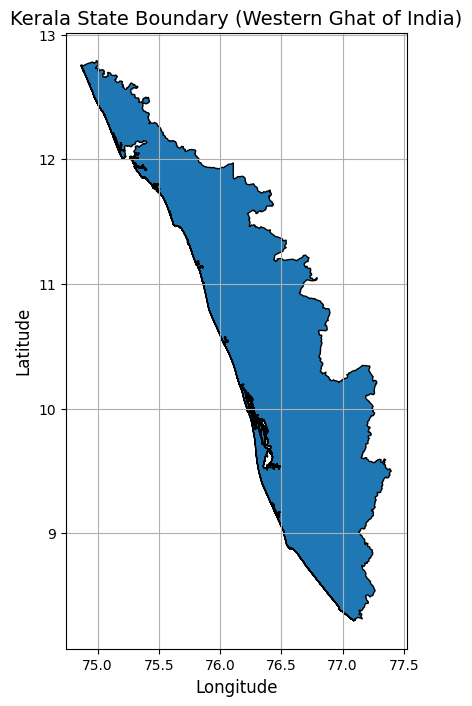

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the shapefile
protect_area = gpd.read_file("/content/drive/MyDrive/BITS_PILANI_RESEARCH/Data/StudyArea/Kerala_StateBoundary.shp")

# Preview spatial data
print(protect_area.head())

# Plot with axis labels and title
fig, ax = plt.subplots(figsize=(10, 8))
protect_area.plot(ax=ax, edgecolor='black')

# Add title and axis labels
ax.set_title("Kerala State Boundary (Western Ghat of India)", fontsize=14)
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)

plt.grid(True)  # Optional: adds gridlines for better readability
plt.show()

# (2) Model implementation

## 2.1 Splitting data

In [3]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# 0) Copy and ensure chronological order by timestamp
df = kerala_clean_merge_data.copy()
df['WX_TS'] = pd.to_datetime(df['WX_TS'], errors='coerce')  # ensure datetime type [24]
df = df.dropna(subset=['WX_TS']).sort_values('WX_TS').reset_index(drop=True)  # sort chronologically [21]

# 1) Select features (X) and targets (y)
feature_cols = [
    "TEMP. ('C)",
    "RH (%)",
    "RAIN FALL CUM. SINCE 0300 UTC (mm)",
    'WIND SPEED 10 m (Kt)'
]  # inputs [25]

target_cols = ['fire_occurrence','fire_count']  # multi-output target [25]

X = df[feature_cols].copy()
y = df[target_cols].copy()
t = df['WX_TS'].copy()

# 2) Chronological 70/15/15 split indices (no shuffle)
N = len(df)
train_end = int(N * 0.70)                 # 70% train [21]
val_end   = int(N * 0.85)                 # next 15% validation [21]

X_train, X_val, X_test = X.iloc[:train_end], X.iloc[train_end:val_end], X.iloc[val_end:]
y_train, y_val, y_test = y.iloc[:train_end], y.iloc[train_end:val_end], y.iloc[val_end:]
t_train, t_val, t_test = t.iloc[:train_end], t.iloc[train_end:val_end], t.iloc[val_end:]

# 3) Impute and scale using TRAIN-ONLY statistics to avoid leakage
imputer = SimpleImputer(strategy='median')                          # robust imputation [22]
scaler  = StandardScaler()                                          # z-score normalization [23]

X_train_imp = imputer.fit_transform(X_train)                        # fit on train only [22]
X_val_imp   = imputer.transform(X_val)                              # transform val [22]
X_test_imp  = imputer.transform(X_test)                             # transform test [22]

X_train_scaled = scaler.fit_transform(X_train_imp)                  # fit scaler on train only [22][23]
X_val_scaled   = scaler.transform(X_val_imp)                        # transform val [22]
X_test_scaled  = scaler.transform(X_test_imp)                       # transform test [22]

# 4) Build sliding-window sequences (samples, timesteps, features) for LSTM
def make_sequences(X_arr, y_df, t_series, lookback=48):
    """
    Create sliding-window sequences for LSTM:
      X_seq: (M, lookback, F)
      y_seq: (M, Y)  -> targets at the window end
      t_end: timestamps at window end
      end_idx: integer indices of window ends
    """
    # Validate aligned lengths
    N, F = X_arr.shape
    Y = y_df.shape[1]

    if N <= lookback:
        return (np.empty((0, lookback, F), dtype=X_arr.dtype),
                np.empty((0, Y), dtype=float),
                pd.Series([], dtype='datetime64[ns]'),
                np.array([], dtype=int))

    X_seq, y_seq, t_end, end_idx = [], [], [], []

    for i in range(lookback, N):
        X_seq.append(X_arr[i - lookback:i, :])
        y_seq.append(y_df.iloc[i].to_numpy())
        t_end.append(t_series.iloc[i])
        end_idx.append(i)

    return (np.asarray(X_seq),
            np.asarray(y_seq),
            pd.Series(t_end),
            np.asarray(end_idx, dtype=int))

# Choose lookback (e.g., 48 hourly steps) as temporal context for LSTM
lookback = 48  # adjust per your sampling frequency and accuracy needs [27][25]

# 5) Build sequences across the full series scaled by train stats, then mask into splits by end-index
X_all_scaled = np.vstack([X_train_scaled, X_val_scaled, X_test_scaled])  # scaled consistently via train stats [22]
y_all = pd.concat([y_train, y_val, y_test], axis=0).reset_index(drop=True)  # align targets [21]
t_all = pd.concat([t_train, t_val, t_test], axis=0).reset_index(drop=True)  # align times [21]

X_seq_all, y_seq_all, t_seq_end, end_idx = make_sequences(X_all_scaled, y_all, t_all, lookback=lookback)  # sequences for LSTM [25][27]

# Translate split boundaries into sequence space based on window end indices
train_mask = end_idx < train_end  # windows ending in train segment [21]
val_mask   = (end_idx >= train_end) & (end_idx < val_end)  # windows ending in val segment [21]
test_mask  = end_idx >= val_end  # windows ending in test segment [21]

X_train_seq, y_train_seq, t_train_seq_end = X_seq_all[train_mask], y_seq_all[train_mask], t_seq_end[train_mask]  # train sequences [25]
X_val_seq,   y_val_seq,   t_val_seq_end   = X_seq_all[val_mask],   y_seq_all[val_mask],   t_seq_end[val_mask]    # val sequences [25]
X_test_seq,  y_test_seq,  t_test_seq_end  = X_seq_all[test_mask],  y_seq_all[test_mask],  t_seq_end[test_mask]   # test sequences [25]

# 6) Sanity checks
print("Flat (pre-sequence) shapes:")
print("  X_train:", X_train.shape, "X_val:", X_val.shape, "X_test:", X_test.shape)  # verify 70/15/15 [21]
print("  y_train:", y_train.shape, "y_val:", y_val.shape, "y_test:", y_test.shape)  # targets aligned [21]
print("Time ranges (flat):")
print("  Train:", t_train.min(), "->", t_train.max(), "| Val:", t_val.min(), "->", t_val.max(), "| Test:", t_test.min(), "->", t_test.max())  # ranges [24]

print("\nSequence (LSTM) shapes:")
print("  X_train_seq:", X_train_seq.shape, "y_train_seq:", y_train_seq.shape)       # (samples, timesteps, features) [25]
print("  X_val_seq:",   X_val_seq.shape,   "y_val_seq:",   y_val_seq.shape)         # validation sequences [25]
print("  X_test_seq:",  X_test_seq.shape,  "y_test_seq:",  y_test_seq.shape)        # test sequences [25]
print("Sequence end time ranges:")
print("  Train end:", t_train_seq_end.min(), "->", t_train_seq_end.max())
print("  Val   end:", t_val_seq_end.min(),   "->", t_val_seq_end.max())
print("  Test  end:", t_test_seq_end.min(),  "->", t_test_seq_end.max())


Flat (pre-sequence) shapes:
  X_train: (5417, 4) X_val: (1161, 4) X_test: (1161, 4)
  y_train: (5417, 2) y_val: (1161, 2) y_test: (1161, 2)
Time ranges (flat):
  Train: 2022-12-14 00:30:00 -> 2023-08-03 00:30:00 | Val: 2023-08-03 01:30:00 -> 2023-09-27 20:30:00 | Test: 2023-09-27 21:30:00 -> 2023-11-22 23:30:00

Sequence (LSTM) shapes:
  X_train_seq: (5369, 48, 4) y_train_seq: (5369, 2)
  X_val_seq: (1161, 48, 4) y_val_seq: (1161, 2)
  X_test_seq: (1161, 48, 4) y_test_seq: (1161, 2)
Sequence end time ranges:
  Train end: 2022-12-16 00:30:00 -> 2023-08-03 00:30:00
  Val   end: 2023-08-03 01:30:00 -> 2023-09-27 20:30:00
  Test  end: 2023-09-27 21:30:00 -> 2023-11-22 23:30:00


### 2.1.1 check class imbalance

In [7]:
np.bincount(y_train_seq[:, 0].astype(int))

array([5319,   50])

### 2.1.2 compute class weight for fire occur

In [8]:
from sklearn.utils import class_weight
import numpy as np

# Extract the fire occurrence column (0 or 1)
occ_y_train = y_train_seq[:, 0].astype(int)

# Compute balanced class weights
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(occ_y_train),
    y=occ_y_train
)

# Convert to dictionary format expected by Keras
class_weights_dict = dict(enumerate(weights))

print("Class weights for fire_occurrence:", class_weights_dict)


Class weights for fire_occurrence: {0: np.float64(0.5047001316036849), 1: np.float64(53.69)}


### 2.1.3 Class weight trianed

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

lookback = X_train_seq.shape[1]       # 48
n_features = X_train_seq.shape[2]     # 4

inputs = keras.Input(shape=(lookback, n_features), name="seq_in")

x = layers.SpatialDropout1D(0.2)(inputs)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(32, return_sequences=True))(x)

attn_out = layers.MultiHeadAttention(num_heads=2, key_dim=32)(x, x)
x = layers.Add()([x, attn_out])
x = layers.LayerNormalization()(x)

x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation="relu")(x)

# Output layer: binary classification (fire_occurrence)
output = layers.Dense(1, activation="sigmoid", name="fire_occurrence")(x)

model = keras.Model(inputs=inputs, outputs=output)
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name='auc')]
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ seq_in (InputLayer) │ (None, 48, 4)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d   │ (None, 48, 4)     │          0 │ seq_in[0][0]      │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 48, 128)   │     35,328 │ spatial_dropout1… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 48, 64)    │     41,216 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 48, 64)    │     16,640 │ bidirectional_1[… │
│ (MultiHeadAttentio… │                   │            │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 48, 64)    │          0 │ bidirectional_1[… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 48, 64)    │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      4,160 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fire_occurrence     │ (None, 1)         │         65 │ dense[0][0]       │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 97,537 (381.00 KB)

 Trainable params: 97,537 (381.00 KB)

 Non-trainable params: 0 (0.00 B)

### 2.1.4 Run the model

In [10]:
history = model.fit(
    X_train_seq,
    y_train_seq[:, 0],
    validation_data=(X_val_seq, y_val_seq[:, 0]),
    epochs=50,
    batch_size=32,
    class_weight={0: 0.5047, 1: 53.69},
    callbacks=[
        keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5)
    ]
)

Epoch 1/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 29s 113ms/step - accuracy: 0.7616 - auc: 0.6592 - loss: 0.6359 - val_accuracy: 0.9974 - val_auc: 0.0000e+00 - val_loss: 0.1001 - learning_rate: 0.0010
Epoch 2/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 21s 123ms/step - accuracy: 0.7611 - auc: 0.8467 - loss: 0.4455 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 0.0831 - learning_rate: 0.0010
Epoch 3/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 39s 112ms/step - accuracy: 0.6656 - auc: 0.7929 - loss: 0.5577 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 0.0969 - learning_rate: 0.0010
Epoch 4/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 20s 107ms/step - accuracy: 0.7232 - auc: 0.7895 - loss: 0.4946 - val_accuracy: 0.9957 - val_auc: 0.0000e+00 - val_loss: 0.1985 - learning_rate: 0.0010
Epoch 5/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 23s 120ms/step - accuracy: 0.7415 - auc: 0.7904 - loss: 0.5409 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 0.0705 - learning_rate: 0.0010
Epoch 6/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 21s 1

In [12]:
test_results = model.evaluate(X_test_seq, y_test_seq[:, 0])
print("Test results:", dict(zip(model.metrics_names, test_results)))

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9840 - auc: 0.0000e+00 - loss: 0.0768
Test results: {'loss': 0.15997709333896637, 'compile_metrics': 0.9448751211166382}


### 2.1.5 Printing the accuracy matrix

In [13]:
from sklearn.metrics import confusion_matrix, classification_report

# Predict probabilities
y_probs = model.predict(X_test_seq)

# Threshold to get class predictions (default 0.5)
y_preds = (y_probs.flatten() > 0.5).astype(int)

# Ground truth
y_true = y_test_seq[:, 0].astype(int)

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_preds))

# Classification report (includes precision, recall, F1)
print("\nClassification Report:")
print(classification_report(y_true, y_preds, digits=4))


37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step
Confusion Matrix:
[[1097   64]
 [   0    0]]

Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9449    0.9717      1161
           1     0.0000    0.0000    0.0000         0

    accuracy                         0.9449      1161
   macro avg     0.5000    0.4724    0.4858      1161
weighted avg     1.0000    0.9449    0.9717      1161



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 2.2 Model architecture: Bi-directional Stat LSTM

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Shapes
lookback = X_train_seq.shape[1]     # timesteps
n_features = X_train_seq.shape[2]   # input features

# ===== Input layer =====
inputs = keras.Input(shape=(lookback, n_features), name="seq_in")  # Input layer: (timesteps, features)

# ===== Hidden layers =====
# Regularize feature maps across timesteps
x = layers.SpatialDropout1D(0.2, name="spatialdrop_1")(inputs)  # Hidden layer: SpatialDropout1D

# Stacked bidirectional LSTMs (first returns sequences for attention)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True), name="bilstm_1")(x)  # Hidden layer: BiLSTM
x = layers.Bidirectional(layers.LSTM(32, return_sequences=True), name="bilstm_2")(x)  # Hidden layer: BiLSTM (stack)

# Self-attention over the sequence
attn_out = layers.MultiHeadAttention(num_heads=2, key_dim=32, name="mha_self")(x, x)  # Hidden layer: MultiHeadAttention

# Residual fusion + normalization
x = layers.Add(name="attn_residual")([x, attn_out])  # Hidden layer: residual add
x = layers.LayerNormalization(name="attn_ln")(x)     # Hidden layer: normalization

# Pool sequence to a fixed-size vector
x = layers.GlobalAveragePooling1D(name="gap")(x)     # Hidden layer: pooling
x = layers.Dropout(0.2, name="drop_post")(x)         # Hidden layer: dropout
x = layers.Dense(64, activation="relu", name="dense_1")(x)  # Hidden layer: dense

# ===== Output layers =====
occ_out = layers.Dense(1, activation="sigmoid", name="occ_out")(x)     # Output layer: fire_occurrence (binary)
cnt_out = layers.Dense(1, activation="softplus", name="cnt_out")(x)    # Output layer: fire_count (non-negative)

model = keras.Model(inputs=inputs, outputs=[occ_out, cnt_out], name="stacked_bilstm_attention")
model.summary()

Model: "stacked_bilstm_attention"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ seq_in (InputLayer) │ (None, 48, 4)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatialdrop_1       │ (None, 48, 4)     │          0 │ seq_in[0][0]      │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bilstm_1            │ (None, 48, 128)   │     35,328 │ spatialdrop_1[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bilstm_2            │ (None, 48, 64)    │     41,216 │ bilstm_1[0][0]    │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mha_self            │ (None, 48, 64)    │     16,640 │ bilstm_2[0][0],   │
│ (MultiHeadAttentio… │                   │            │ bilstm_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attn_residual (Add) │ (None, 48, 64)    │          0 │ bilstm_2[0][0],   │
│                     │                   │            │ mha_self[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attn_ln             │ (None, 48, 64)    │        128 │ attn_residual[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap                 │ (None, 64)        │          0 │ attn_ln[0][0]     │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop_post (Dropout) │ (None, 64)        │          0 │ gap[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      4,160 │ drop_post[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ occ_out (Dense)     │ (None, 1)         │         65 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnt_out (Dense)     │ (None, 1)         │         65 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 97,602 (381.26 KB)

 Trainable params: 97,602 (381.26 KB)

 Non-trainable params: 0 (0.00 B)

## 2.3 Compile model

In [5]:
# Split multi-output targets
y_train_occ = y_train_seq[:, 0].astype('float32')
y_train_cnt = y_train_seq[:, 1].astype('float32')

y_val_occ = y_val_seq[:, 0].astype('float32')
y_val_cnt = y_val_seq[:, 1].astype('float32')

y_test_occ = y_test_seq[:, 0].astype('float32')
y_test_cnt = y_test_seq[:, 1].astype('float32')

# Compile with multi-loss
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss={"occ_out": keras.losses.BinaryCrossentropy(from_logits=False),
          "cnt_out": keras.losses.Poisson()},
    loss_weights={"occ_out": 1.0, "cnt_out": 1.0},
    metrics={"occ_out": [keras.metrics.AUC(name="auc"),
                         keras.metrics.BinaryAccuracy(name="acc")],
             "cnt_out": [keras.metrics.MeanAbsoluteError(name="mae")]}
)

# Early stopping and LR scheduling
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss", mode="min", patience=6, restore_best_weights=True, verbose=1
)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", mode="min", factor=0.5, patience=3, min_lr=1e-6, verbose=1
)

# Train up to 50 epochs
history = model.fit(
    X_train_seq,
    {"occ_out": y_train_occ, "cnt_out": y_train_cnt},
    validation_data=(X_val_seq, {"occ_out": y_val_occ, "cnt_out": y_val_cnt}),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Evaluate on test
eval_res = model.evaluate(
    X_test_seq, {"occ_out": y_test_occ, "cnt_out": y_test_cnt}, verbose=1, return_dict=True
)
print("Test results:", eval_res)

# Predict (optional)
y_pred_occ, y_pred_cnt = model.predict(X_test_seq, verbose=0)


Epoch 1/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 33s 121ms/step - cnt_out_loss: 0.1870 - cnt_out_mae: 0.1350 - loss: 0.2961 - occ_out_acc: 0.9628 - occ_out_auc: 0.7004 - occ_out_loss: 0.1091 - val_cnt_out_loss: 0.0023 - val_cnt_out_mae: 0.0023 - val_loss: 0.0039 - val_occ_out_acc: 1.0000 - val_occ_out_auc: 0.0000e+00 - val_occ_out_loss: 0.0017 - learning_rate: 0.0010
Epoch 2/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 18s 108ms/step - cnt_out_loss: 0.1495 - cnt_out_mae: 0.0766 - loss: 0.2086 - occ_out_acc: 0.9888 - occ_out_auc: 0.7113 - occ_out_loss: 0.0591 - val_cnt_out_loss: 6.6587e-04 - val_cnt_out_mae: 6.6696e-04 - val_loss: 9.5666e-04 - val_occ_out_acc: 1.0000 - val_occ_out_auc: 0.0000e+00 - val_occ_out_loss: 2.8986e-04 - learning_rate: 0.0010
Epoch 3/50
168/168 ━━━━━━━━━━━━━━━━━━━━ 21s 108ms/step - cnt_out_loss: 0.1262 - cnt_out_mae: 0.0795 - loss: 0.1669 - occ_out_acc: 0.9928 - occ_out_auc: 0.7320 - occ_out_loss: 0.0407 - val_cnt_out_loss: 0.0012 - val_cnt_out_mae: 0.0012 - val_loss: 0.0020 - val_oc

In [6]:
from sklearn.utils import class_weight

# Compute weights automatically
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_seq[:, 0]),
    y=y_train_seq[:, 0]
)

# Apply only to occ_out
loss_weights = {"occ_out": 1.0, "cnt_out": 1.0}  # You can adjust

model.fit(
    X_train_seq,
    {"occ_out": y_train_seq[:, 0], "cnt_out": y_train_seq[:, 1]},
    validation_data=(
        X_val_seq,
        {"occ_out": y_val_seq[:, 0], "cnt_out": y_val_seq[:, 1]}
    ),
    class_weight={"occ_out": dict(enumerate(class_weights))},  # Apply to classification head
    epochs=50,
    batch_size=32,
    callbacks=[...],
)


ValueError: `class_weight` is only supported for Models with a single output.

##